# Low Number of Ratings

When you sign up for a service, there is minimal information about you. If an app uses facebook for sign on or has some idea about your from cookies or demographic information this can be used to make a model of your preferences, but often the most important information is not contained in this.

For example Netflix might know that I'm a 27 year old guy from Calgary but they don't know a lot more until I start watching movies and rating/skipping them. 

The more movies I rate the better a model they get of me and my preferences. This is inefficent because I quickly want to be shown movies that I enjoy.

## Twenty Questions

You might be familiar with the game Twenty Questions. In it, participants must determine a player's 'identity' from only asking twenty questions. 

I believe that a similar approach can be implemented using user ratings data. In a [previous assignment](https://github.com/kaiserxc/DATA643/blob/master/Project%201/KLukowiakAssignment1.ipynb) I used a dataset of joke ratings to design a recomender system. 

In effect it just added row and colum means to missing values and performed relitively poorly. The jokes all had a lot of ratings, making it difficiult for my recomender to addapt to new people who have less information. 

We will use a 'Twenty Question' approach to bisect the data to get the most important jokes to show. Baisically, we are trying to find the most important jokes to be rated in order to get a good recomender for all other jokes. Once these few jokes are rated, the highest ranking jokes can be shown to the user for max enjoyment.

In [1]:
import pandas as pd
import numpy as np
jokes = pd.read_pickle('Jokes.pickle')
jokes = jokes.iloc[:, 1:].replace(99, np.nan) # For clustering
jokes.head()

1     2     3     4     5     6     7     8     9     10   ...    91   \
0 -7.82  8.79 -9.66 -8.16 -7.52 -8.50 -9.85  4.17 -8.98 -4.76  ...   2.82   
1  4.08 -0.29  6.36  4.37 -2.38 -9.66 -0.73 -5.34  8.88  9.22  ...   2.82   
2   NaN   NaN   NaN   NaN  9.03  9.27  9.03  9.27   NaN   NaN  ...    NaN   
3   NaN  8.35   NaN   NaN  1.80  8.16 -2.82  6.21   NaN  1.84  ...    NaN   
4  8.50  4.61 -4.17 -5.39  1.36  1.60  7.04  4.61 -0.44  5.73  ...   5.19   

    92    93    94    95    96    97    98    99    100  
0   NaN   NaN   NaN   NaN   NaN -5.63   NaN   NaN   NaN  
1 -4.95 -0.29  7.86 -0.19 -2.14  3.06  0.34 -4.32  1.07  
2   NaN   NaN  9.08   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN  0.53   NaN   NaN   NaN   NaN   NaN   NaN  
4  5.58  4.27  5.19  5.73  1.55  3.11  6.55  1.80  1.60  

[5 rows x 100 columns]

In [2]:
N = jokes.size
import numpy as np
print('There are ', N, ' people in the dataset.')
print('There are log2(N) decisions to split the data set perfectly. This works out to be:', np.log2(N))

There are  2498300  people in the dataset.
There are log2(N) decisions to split the data set perfectly. This works out to be: 21.2525152979


---
## Number of Questions

We don't need to split it perfectly though as this would probably involve over fitting. Working backwards, there will be aproximetly 2 people in the 20th decision, 4 in the 19th, 8 in the 18th, 16 in the 17, and 32 in the 16th. 32 is a good number to start at because drawing an average from it should hold with the CLT.

In practice, this doesn't quite work as my bisection technique often doesn't split it exactly in half. 

---

## Selection

Based on the answer to a certain joke, the users will be bisected with a binary search algorithm and new splitting question will be asked. 

To do this, we need to first cluster the users and then make a tree based descriminator.

----

We will use unsupervised learning to classify people. Since our dataset has a high number of dimensions (100) we have to can't really use a eucludian algorithm like KNN. Instead we will use PCA. 

---

## Number of Groups

We want no fewer than 32 people in a group. 

---

## Train/Test Split

In the previous assignment, I randomly selected terms in the dataframe to act as training and testing data. This is preferable, however, since I don't now which questions will be asked, I need to use users who answered all questions as my test set. This is unfurtunate, but in the real world, we would validate on new users who had to answer whatever questions we asked. 

In [3]:
completeCases = jokes.dropna()
numSample = np.int(completeCases.shape[0]*0.2)
trainTest = completeCases.sample(numSample, random_state=101).index
testDF = jokes.loc[trainTest]
trainDF = jokes.loc[~jokes.index.isin(trainTest)]

In [4]:
jokes.index.isin(trainTest)

array([False,  True, False, ..., False, False, False], dtype=bool)

In [5]:
print(testDF.shape)
trainDF.shape

(1440, 100)


(23543, 100)

In [6]:
print(1440 + 23543)
print(jokes.shape)

24983
(24983, 100)


In [7]:
def maxVarFinder(df, newUser):
    colLoc = df.var().idxmax()
    cutOff = df[colLoc].median()
    if newUser[colLoc] > cutOff: # New users should be the result of the question, but we don't have that yet.
        df = df[df[colLoc] > cutOff]
    else:
        df = df[df[colLoc] <= cutOff]
    return df    

In [8]:
def rmseFinder(df, newUser):
    rawMean = df.stack().mean()
    colMean = df.mean()
    rowMean = 0 # add to this with a map of used values to get more accurate count.
    testVec = np.full(df.shape[1], rawMean)
    testVec += colMean
    # testVec=testVec + rowMean[:,np.newaxis] ## After you implement mapping ^^
    rmse = np.sqrt(((newUser - testVec)**2).mean())
    return rmse
    

In [9]:
def splitter(df, newUser, numItters):
    RMSE = []
    i=0
    while i <= numItters:
        df = maxVarFinder(df, newUser)
        RMSE.append(rmseFinder(df, newUser))
        i = 1+i
    return RMSE

In [10]:
splitter(trainDF, testDF.loc[5440,:], 9)

[5.7877612847278987,
 5.402583151563662,
 5.5562909536714518,
 5.3346332881945742,
 5.3789712383039943,
 5.5419636142487123,
 5.2251425068097515,
 5.237052927002674,
 5.6574413419206326,
 6.2469625547140932]

In [11]:
testDF.sample()

1     2     3    4     5     6     7     8     9     10   ...    91   \
15499  2.91 -3.93 -8.74 -8.4 -2.33 -6.99 -4.03 -8.59 -8.69 -4.81  ...  -2.43   

        92    93    94    95    96    97    98    99    100  
15499  1.26 -4.37  1.46 -2.14 -2.09 -7.09  3.45 -6.21 -6.55  

[1 rows x 100 columns]

In [16]:
def aggrigatedPreds(trainDF, testDF, numItters):
    aggRMSE = []
    for i in testDF.index:
        tempRMSE = splitter(trainDF, testDF.loc[i,:], numItters)
        aggRMSE.append(tempRMSE)
        
    return aggRMSE
        
GraphData = aggrigatedPreds(trainDF, testDF.sample(50), 9)

In [17]:
GraphData = pd.DataFrame(GraphData)
GraphData.head()

0         1         2         3         4         5         6  \
0  2.674569  2.229359  2.537098  2.219247  2.552381  2.393708  2.621780   
1  4.711772  5.543970  6.495019  5.903538  5.393502  4.341232  4.273267   
2  6.497356  5.762979  6.441259  7.262696  6.745580  6.251185  5.729479   
3  5.524368  5.140403  5.252836  5.696545  5.317325  5.200451  5.364570   
4  3.557467  3.706497  3.438013  3.589600  3.372845  3.353894  3.869140   

          7         8         9  
0  2.667879  2.840596  2.982462  
1  4.233782  4.442457  4.404020  
2  6.057098  5.662738  5.508264  
3  5.001235  5.106585  4.925155  
4  4.914720  5.077839  4.636633

In [14]:

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

def remover(p):
    # Set axis to invisiable
    p.xaxis.axis_line_width = 0.00001
    p.yaxis.axis_line_width = 0.00001
    # Fonts
    p.title.text_font = "times"
    p.title.text_font_style = "normal"
    p.xaxis.axis_label_text_font = 'times'
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font = 'times'
    p.yaxis.axis_label_text_font_style = 'normal'
    # This removes the outline of the graph.
    p.outline_line_color = None
    p.toolbar.logo = None
    p.toolbar_location = None
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

Loading BokehJS ...

In [27]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

p1 = figure(title="Optimal number of Splits")
x = list(GraphData.columns)
for i in GraphData.index:
    y=GraphData.loc[i]
    p1.line(x=x, y=y, color='grey', alpha=0.3) 
p1.line(x=x, y=GraphData.mean(), color='black') 
p1 = remover(p1)
p1.xaxis.axis_label = "Number of Binary Splits"
p1.yaxis.axis_label = "RMSE"

show(p1)

## Results
This did not really work, if anything, there is a slight upward trend in RMSE as we split the data. 

My hypothesis for this performance, is that there was so little correlation between the variables that it just acted as a random selection. It would be interesting to see this approach on a different dataset.

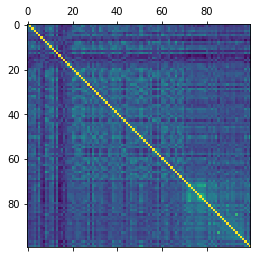

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(jokes.corr())

In [33]:
trainDFZeros = trainDF.fillna(0)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(trainDFZeros)

In [36]:
kmeans.labels_.shape

(23543,)

In [47]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(trainDFZeros, kmeans.labels_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [57]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)


import graphviz 
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

 
graph 


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U217') dtype('<U217') dtype('<U217')

In [56]:
graph

In [59]:
dt.__getstate__()

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'random_state': 99,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': False,
 'n_features_': 100,
 'n_outputs_': 1,
 'classes_': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24], dtype=int32),
 'n_classes_': 25,
 'max_features_': 100,
 'tree_': <sklearn.tree._tree.Tree at 0x11bcc0ed0>,
 '_sklearn_version': '0.19.0'}

In [67]:
treeNodes = dt.tree_.__getstate__()['nodes']

In [74]:
treeNodes[859]

(860, 1569, 6, -3.32499981,  0.91376146, 11093,  11093.)

In [72]:
treeNodes[2]

(3, 90, 77, -3.42500019,  0.9312948, 4478,  4478.)

In [75]:
treeNodes.dtype

dtype([('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')])

In [113]:
def treeTraverser(trainDF, newUser, treeObj, nLayers):
    i = 0
    RMSE = []
    j = 0
    while i < nLayers:
        feature = treeObj[j][2] # feature Number for criteria.
        criteria = treeObj[j][3]
        if newUser[feature] >= criteria:
            j = treeNodes[j][1]
            trainDF = trainDF[trainDF[feature] >= criteria]
        else:
            j=treeNodes[j][0]
            trainDF = trainDF[trainDF[feature] < criteria]
        x = rmseFinder(trainDF, newUser)
        RMSE.append(x)
        print(x)
        i = i+1
    return RMSE
    
treeTraverser(trainDF, testDF.loc[24292,:],treeNodes, 4)

4.45212102516
3.80841969125
3.60329123201
3.46097893912


[4.4521210251617882,
 3.8084196912524466,
 3.6032912320139161,
 3.4609789391233274]

In [115]:
def aggrigatedPredsTree(trainDF, testDF, treeObj, numItters):
    aggRMSE = []
    for i in testDF.index:
        tempRMSE = splitter(trainDF, testDF.loc[i,:], numItters)
        aggRMSE.append(tempRMSE)
        
    return aggRMSE
        
GraphData1 = aggrigatedPredsTree(trainDF, testDF.sample(50), treeNodes, 4)

In [116]:
GraphData1

[[3.6208276818742582,
  4.1554922491931787,
  3.5826030606260675,
  3.4946485309099966,
  3.6183386201317971],
 [3.277879891648813,
  3.6744692160384713,
  3.3867010608354815,
  3.5181748948016689,
  3.4544687240024885],
 [3.3828311225309493,
  2.6247970178426194,
  3.1503233357079083,
  2.7127058980599705,
  2.8781525322227619],
 [4.0200779502222685,
  4.1258836341020011,
  4.8133362085689253,
  5.3943344679977612,
  6.5483846397460379],
 [3.1396436196589539,
  3.3834707861729503,
  4.1453339779216787,
  3.5721444800228617,
  3.188763532077949],
 [3.9200776386279861,
  3.2723200651409581,
  3.3812039689730624,
  3.7216586820904149,
  4.7016806927537163],
 [4.7994732287481492,
  5.790682162029622,
  5.0121671654598199,
  4.4787237521902084,
  4.9885940308027301],
 [4.6967366967701674,
  4.3034188858118902,
  4.6500551570523978,
  4.2891697864410272,
  4.1636231779846975],
 [4.5287407855050335,
  4.9827591721880724,
  4.5736022168970321,
  4.5441565053392434,
  4.5214995792559201],
 [6.

In [119]:
GraphData1 = pd.DataFrame(GraphData1)

In [121]:
p1 = figure(title="Optimal number of Splits")
x = list(GraphData1.columns)
for i in GraphData1.index:
    y=GraphData1.loc[i]
    p1.line(x=x, y=y, color='grey', alpha=0.3) 
p1.line(x=x, y=GraphData1.mean(), color='black') 
p1 = remover(p1)
p1.xaxis.axis_label = "Number of Tree Splits"
p1.yaxis.axis_label = "RMSE"

show(p1)